This example shows an application of adaptive dynamic programming (ADP) to a linear system with a constant disturbance term. By combining the output regulation technique, the ADP-based control algorithm can find the optimal control policy.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import inv
from numpy.linalg import matrix_rank
import scipy.io
from scipy import signal
from cvxopt import matrix, solvers
import pylab

Build envrionment for simulation
$$
x_{k+1} = Ax_{k}+Bu_{k}+D
$$

Objective: find a feedback controller $$u_{k} = - Kx_{k}+U$$ to force the state $x$ converge to zero. 


Meanwhile, we have the following cost definition
\begin{equation*}
\begin{aligned}
& \underset{\bar{u}}{\text{minimize}}
& & \sum_{k=0}^{\infty}x_{k}^{T}Qx_{k} + r  \bar{u}_{k} ^{2}  \\
& \text{subject to}
& & x_{k+1} = Ax_{k} + B\bar{u}_{k}
\end{aligned}
\end{equation*}
where $Q=Q^{T}\geq 0$, $r>0$, $\bar{u}_{k}=u_{k}-U^{*}$ and $U^{*}$ is an unknown vector. 

In [2]:
A = np.array([[0.5851, -0.0004], 
              [-35.7490, 0.2999]])
B = np.array([[-0.0064,0.0001,0,-0.0001],
              [-0.2248,-0.0060,0.0061,0.0020]])

D = np.array([[0.0185], 
              [0]])

def env(x, u):
    x_ = A @ x + B @ u + D
    return x_

# In memory, we store state, action, reward, and successor state
def store_transition(x, u, x_):
    global memory_size, memory_counter, memory
    transition = np.hstack((x.transpose(), u.transpose(), x_.transpose()))
    # replace the old memory with new memory
    index = memory_counter % memory_size
    memory[index, :] = transition
    memory_counter += 1

Initial control policy

In [3]:
# current best poles
Poles = np.array([0.8, 0.88])
K0 = signal.place_poles(A, B, Poles).gain_matrix


Model-based method to solve the control problem

In [4]:
matrix_aug_01 = np.hstack((A-np.eye(2), B))
matrix_aug_02 = np.hstack((np.eye(2), np.zeros((2,4))))
matrix_aug = np.vstack((matrix_aug_01, matrix_aug_02))
rank_reg = matrix_rank(matrix_aug)

## cost (reward) design
Q = np.array([[1e-5, 0],
              [0, 1e5]])
R = np.eye(4)
Pstar = scipy.linalg.solve_discrete_are(A, B, Q, R)
Kstar = np.matrix(scipy.linalg.inv(B.transpose()@Pstar@B+R)@(B.transpose()@Pstar@A))

##########
# model-based value iteration algorithm
iter_max = 50
P_traj = np.zeros((iter_max, 2, 2))
APB_traj = np.zeros((iter_max, 2, 4))
APD_traj = np.zeros((iter_max, 2, 1))
for i in range(iter_max-1):
    P = P_traj[i, :, : ]
    APB_traj[i, :, : ] = A.transpose()@P@B
    APD_traj[i, :, : ] = A.transpose()@P@D
    P_traj[i+1, :, : ] = Q + A.transpose()@P@A - A.transpose()@P@B@scipy.linalg.inv(R+B.transpose()@P@B)@B.transpose()@P@A
###########

###########
## model-based solution Hstar
H11_star = B.transpose()@Pstar@B
H12_star = B.transpose()@Pstar@D
H13_star = B.transpose()@Pstar@A
H21_star = H12_star.transpose()
H22_star = D.transpose()@Pstar@D
H23_star = D.transpose()@Pstar@A
H31_star = H13_star.transpose()
H32_star = H23_star.transpose()
H33_star = A.transpose()@Pstar@A
H1_star = np.concatenate((H11_star,H12_star,H13_star), axis=1)
H2_star = np.concatenate((H21_star,H22_star,H23_star), axis=1)
H3_star = np.concatenate((H31_star,H32_star,H33_star), axis=1)
Hstar = np.concatenate((H1_star,H2_star,H3_star), axis=0)
###########

### model-based method to computer the feedforward term
Rbar = np.eye(4)
#P = np.array([[1.0]])
P = 2*matrix(Rbar)
q = matrix([[0.0, 0.0, 0.0, 0.0]])
G = matrix(B)
h = matrix(-D)

M=np.array([[1.0,0,0,0], 
                     [0,1,0,0],
                     [0,0,1,0],
                     [0,0,0,1],
                     [-1,0,0,0],
                     [0,-1,0,0],
                     [0,0,-1,0],
                     [0,0,0,-1]])
M = matrix(M)
N = matrix(np.array([[7.5],
                     [420],
                     [600],
                     [60],
                     [-7.0],
                     [-350],
                     [-370],
                     [0]]))
#sol = solvers.qp(P,q,None,None,G,h)
M = matrix(M)
sol = solvers.qp(P,q,M,N,G,h)
Ustar = np.array(sol['x']) 

     pcost       dcost       gap    pres   dres
 0:  9.8315e+04  2.2170e+05  4e+05  7e-01  8e-14
 1:  3.1174e+05  4.2126e+05  2e+05  2e-01  1e-11
 2:  4.8708e+05  4.7432e+05  2e+04  8e-03  2e-12
 3:  4.8406e+05  4.8349e+05  8e+02  2e-04  3e-12
 4:  4.8389e+05  4.8387e+05  2e+01  2e-06  4e-12
 5:  4.8388e+05  4.8388e+05  2e-01  2e-08  2e-12
Optimal solution found.


In [5]:
# Simulation
time_max = 30
memory_size = time_max
memory_counter = 0
memory = np.zeros((memory_size,8))

## variance of the exploration noise
sigma = 0.1
x_init = np.array([0,0.5])
x = x_init[:, np.newaxis]
for i in range(time_max):
    step = 0
    noise = np.random.normal(np.array([0, 0, 0, 0]), np.array([sigma, sigma, sigma, sigma]))[:, np.newaxis]
    ## initial controller
    u = 0.85*Ustar + noise
    x_ = env(x, u)
    store_transition(x, u, x_)
    x = x_
    step += 1

x_traj_0 = memory[:, 0]
x_traj_1 = memory[:, 1]
u_traj = memory[:, 2:6].transpose()

Off-policy learning

In [6]:
data_transition = memory[0,:][np.newaxis, :]
x = data_transition[:, :2]
u = data_transition[:, 2:6]
x_ = data_transition[:, -2:]

## vectorize operator for a matrix
temp1 = np.kron(np.hstack((u,np.eye(1),x)), np.hstack((u,np.eye(1),x)))
# vecv operation
a = np.arange(49).reshape(7, 7)
index_vecv = np.triu_indices(7)
temp2 = a[index_vecv]
temp3 = temp1[:,temp2]
def vecv(x, v, u):
    kron_product = np.kron(np.hstack((u,v,x)), np.hstack((u,v,x)))
    temp2 = a[index_vecv]
    result = kron_product[:,temp2]
    return result
result = vecv(x, np.eye(1), u)

## algorithm begins here
iter_max = 40
size_XY = time_max
size_batch = 1
size_memory = memory.shape[0]

H = np.zeros((7,7))
H11 = np.zeros((4,4))
H13 = np.zeros((4,2))
H33 = np.zeros((2,2))
H32 = np.zeros((2,1))
AP_jB_data_traj = np.zeros((iter_max, 2, 4))
AP_jD_data_traj = np.zeros((iter_max, 2, 1))
errorH = np.zeros(iter_max)
errorK = np.zeros(iter_max)
for iter in range(iter_max):
    X = np.zeros((size_XY,  temp2.shape[0]))
    Y = np.zeros((size_XY,  1))
    AP_jB = H13.transpose()
    AP_jD = H32
    AP_jB_data_traj[iter, :, :] = AP_jB
    AP_jD_data_traj[iter, :, :] = AP_jD
    
    for i in range(size_XY):
        data_selected = memory[i, :][np.newaxis, :]
        x = data_selected[:, :2].transpose()
        u = data_selected[:, 2:6].transpose()
        x_ = data_selected[:, -2:].transpose()
        X[i, :] = vecv(x.transpose(), np.eye(1), u.transpose()) # psi
        phi = x_.transpose()@(H33 - H13.transpose()@scipy.linalg.inv((R+H11))@H13)@x_
        Y[i, :] = x_.transpose()@ Q @x_ + phi
        
    lstsq_result = np.linalg.lstsq(X, Y, rcond=None)
    pp = lstsq_result[0]
    res = lstsq_result[1]
    
    temp5 = np.zeros((7,7))
    l = 0
    for m in range(7):
        for n in range(m, 7):
            temp5[m, n] = pp[l]
            l = l+1
    
    H = (temp5 + temp5.transpose())/2.0
    err_H = np.linalg.norm(H-Hstar)
    errorH[iter] = err_H

    H33 = H[5:, 5:]
    H11 = H[:4, :4]
    H13 = H[:4, 5:]
    H32 = H[5:, 4][:, np.newaxis]
    K = scipy.linalg.inv((R+H11))@H13
    
    err_K = np.linalg.norm(K-Kstar)
    errorK[iter] = err_K
    
    if (err_H < 1e-2):
        break
        
APB = AP_jB 
APD = AP_jD        
U_dag = np.linalg.lstsq(H13.transpose(), -H32, rcond=None)[0]
G = matrix(APB)
h = matrix(-APD)

M=np.array([[1.0,0,0,0], 
             [0,1,0,0],
             [0,0,1,0],
             [0,0,0,1],
             [-1,0,0,0],
             [0,-1,0,0],
             [0,0,-1,0],
             [0,0,0,-1]])
M = matrix(M)
N = matrix(np.array([[7.5],
                     [420],
                     [600],
                     [60],
                     [-7.0],
                     [-350],
                     [-370],
                     [0]]))
#sol = solvers.qp(P,q,None,None,G,h)
M = matrix(M)
sol = solvers.qp(P,q,M,N,G,h)
Udag = np.array(sol['x'])

     pcost       dcost       gap    pres   dres
 0:  9.8315e+04  2.2170e+05  4e+05  7e-01  0e+00
 1:  3.1174e+05  4.2126e+05  2e+05  2e-01  6e-11
 2:  4.8708e+05  4.7432e+05  2e+04  8e-03  2e-11
 3:  4.8406e+05  4.8349e+05  8e+02  2e-04  8e-11
 4:  4.8389e+05  4.8387e+05  2e+01  2e-06  8e-11
 5:  4.8388e+05  4.8388e+05  2e-01  2e-08  9e-12
Optimal solution found.


In [7]:
time_simulation_adp = 50
x_traj_after_learning = np.zeros((2, time_simulation_adp))
u_traj_after_learning = np.zeros((4, time_simulation_adp))
#x = np.random.normal(np.array([0.5, 0.5]), np.array([0.0, 0.0]))[:, np.newaxis]
for i in range(time_simulation_adp):
#    u = -K @ x + Udag
    x = x_
    u = -K @ x + Udag
    x_ = env(x, u)
    x_traj_after_learning[:, i] = x_.reshape((2))
    u_traj_after_learning[:, i] = u.reshape((4))
    
############# 

In [8]:
##plots 
fontsize_xylabel = 18
fontsize_ticks = 18
fontsize_legend = 16
linewidth=2
markersize=4

Plots for state trajectory

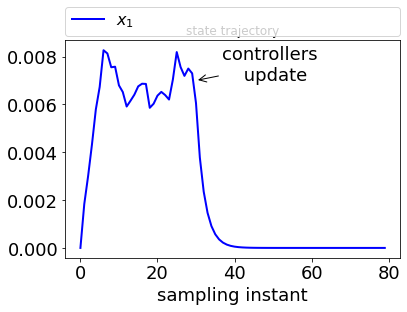

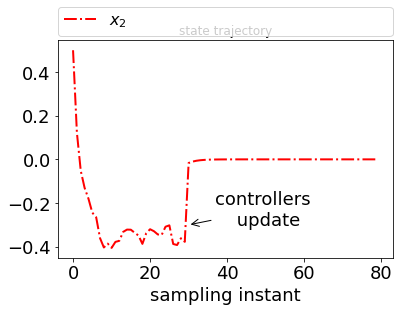

In [15]:
x_traj_0_whole = np.concatenate((x_traj_0[:, np.newaxis], x_traj_after_learning[0,:][:, np.newaxis]), axis=0)
x_traj_1_whole = np.concatenate((x_traj_1[:, np.newaxis], x_traj_after_learning[1,:][:, np.newaxis]), axis=0)
plt.figure(0)
plt.title('state trajectory')
plt.plot(x_traj_0_whole, linestyle='-', linewidth=linewidth, color='blue', label=r'${x}_1$')
#plt.plot(x_traj_1_whole, linestyle='-.', linewidth=linewidth, color='red', label=r'${x}_2$')
plt.xlabel('sampling instant', fontsize=fontsize_xylabel)
plt.tick_params(labelsize=fontsize_ticks)
plt.legend(fontsize=fontsize_legend, loc=0, ncol=1)
plt.annotate(
        'controllers \n update', ha='center', fontsize=fontsize_xylabel,
        xy=(time_max, 0.007), arrowprops=dict(arrowstyle='->'), xytext=(time_max+20, 0.007))
lgd = pylab.legend(fontsize=fontsize_legend,loc=3, mode="expand", bbox_to_anchor=(0., 1.02, 1., .102), 
                   ncol=4, borderaxespad=0.)
art = []
art.append(lgd)
#pylab.savefig("VI_x_traj.png", additional_artists=art, bbox_inches="tight",dpi=200)

plt.figure(1)
plt.title('state trajectory')
#plt.plot(x_traj_0_whole, linestyle='-', linewidth=linewidth, color='blue', label=r'${x}_1$')
plt.plot(x_traj_1_whole, linestyle='-.', linewidth=linewidth, color='red', label=r'${x}_2$')
plt.xlabel('sampling instant', fontsize=fontsize_xylabel)
plt.tick_params(labelsize=fontsize_ticks)
plt.legend(fontsize=fontsize_legend, loc=0, ncol=1)
plt.annotate(
        'controllers \n update', ha='center', fontsize=fontsize_xylabel,
        xy=(time_max, -0.3), arrowprops=dict(arrowstyle='->'), xytext=(time_max+20, -0.3))
lgd = pylab.legend(fontsize=fontsize_legend,loc=3, mode="expand", bbox_to_anchor=(0., 1.02, 1., .102), 
                   ncol=4, borderaxespad=0.)
art = []
art.append(lgd)

Plots for inputs trajectory

Text(0.5, 0, 'sampling instant')

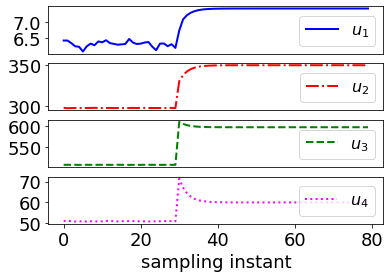

In [17]:
u_traj_whole = np.concatenate((u_traj, u_traj_after_learning), axis=1)
u_traj_whole_0 = u_traj_whole[0,:]
u_traj_whole_1 = u_traj_whole[1,:]
u_traj_whole_2 = u_traj_whole[2,:]
u_traj_whole_3 = u_traj_whole[3,:]

plt.figure(4)
plt.subplot(411)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
#plt.ylabel(r'${u}_1$')
plt.tick_params(labelsize=fontsize_ticks)
plt.plot(u_traj_whole_0, linestyle='-', linewidth=linewidth, color='blue', label=r'${u}_1$')
#plt.plot(u_traj_whole_3, linestyle=':', linewidth=linewidth, color='magenta', label=r'${u}_4$')
plt.legend(fontsize=fontsize_legend, loc=4, ncol=1)
#plt.annotate(
#        'controllers \n update', ha='center', fontsize=fontsize_xylabel,
#        xy=(time_max, 48), arrowprops=dict(arrowstyle='->'), xytext=(time_max-20, 20))
plt.subplot(412)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(labelsize=fontsize_ticks)
plt.plot(u_traj_whole_1, linestyle='-.', linewidth=linewidth, color='red', label=r'${u}_2$')
#plt.plot(u_traj_whole_2, linestyle='--', linewidth=linewidth, color='green', label=r'${u}_3$')
plt.legend(fontsize=fontsize_legend, loc=4, ncol=1)
plt.subplot(413)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.tick_params(labelsize=fontsize_ticks)
plt.plot(u_traj_whole_2, linestyle='--', linewidth=linewidth, color='green', label=r'${u}_3$')
plt.legend(fontsize=fontsize_legend, loc=4, ncol=1)
plt.subplot(414)
plt.plot(u_traj_whole_3, linestyle=':', linewidth=linewidth, color='magenta', label=r'${u}_4$')
plt.tick_params(labelsize=fontsize_ticks)
plt.legend(fontsize=fontsize_legend, loc=4, ncol=1)
plt.xlabel('sampling instant', fontsize=fontsize_xylabel)
# pylab.savefig("VI_u_traj_separated.png", additional_artists=art, bbox_inches="tight",dpi=200)

Plots to show the convergence to the theoretical optimal values

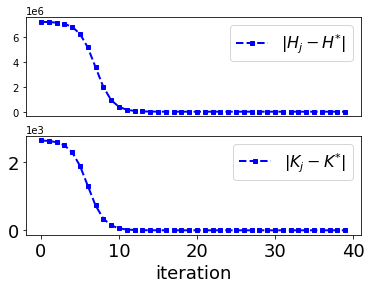

In [18]:
try:
    errorH = np.trim_zeros(errorH)
except:
    pass

try:
    errorK = np.trim_zeros(errorK)
except:
    pass

plt.figure(5)
plt.subplot(211)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.plot(errorH,'bs--',linewidth=linewidth, label=r'$|H_{j}-H^{*}|$', markersize=markersize)
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.legend(fontsize=fontsize_legend, loc=0, ncol=1)
plt.subplot(212)
plt.ticklabel_format(style='sci', axis='y', scilimits=(0,0))
plt.plot(errorK,'bs--',linewidth=linewidth, label=r'$|K_{j}-K^{*}|$', markersize=markersize)
plt.xlabel('iteration', fontsize=fontsize_xylabel)
plt.tick_params(labelsize=fontsize_ticks)
plt.legend(fontsize=fontsize_legend, loc=0, ncol=1)
# pylab.savefig("VI_HK_conv.png", additional_artists=art, bbox_inches="tight",dpi=200)